# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                                                                                                                                                                  
Sample_203  A0A0G2JHA9;A0A0G2JHM8;A0A0G2JI49;A0A0G2JIQ0;A0A0G2JIU9;A0A0G2JJE4;A0A0G2JKI0;A0A140T9L1;C9JTE0;H0Y8A0;Q16653;Q16653-10;Q16653-11;Q16653-13;Q16653-2;Q16653-3;Q16653-5;Q16653-6;Q16653-7;Q16653-8;Q16653-9;Q5SSB8   17.676
Sample_029  Q96KN2                                                                                                                                                                                                             22.263
Sample_151  Q6UVK1                                                                                                                                                                                                             17.527
Sample_008  H3BPK2;H3BQX6;P25713                                                         

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                            
Sample_103  Q14315;Q14315-2                              13.274
Sample_021  A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3   14.257
Sample_032  O43854;O43854-2                              13.328
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.928
            A0A075B6Q5                 11.593
            A0A075B6R2                 12.544
            A0A075B6S5                 12.770
            A0A087WSY4                 12.095
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.755
            Q9UI40;Q9UI40-2            12.334
            Q9UIW2                     12.454
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.875
            Q9UP79                     11.137
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.441,15.050,16.842,19.863,16.130,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.486,19.067,...,15.528,15.576,14.085,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.977,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.399,17.705,17.039,16.071,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.883,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.721,15.345,17.084,18.708,14.249,19.433,11.926,10.665
Sample_207,15.739,16.877,15.469,16.898,13.963,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.928,...,16.012,15.178,13.988,15.050,16.842,19.863,12.928,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.520,19.067,16.188,...,15.528,15.576,13.638,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.565,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.147,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.831,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.878,15.345,17.084,18.708,14.249,19.433,12.479,12.306
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 332.93it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.80it/s]

100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.37it/s]

100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.54it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.53it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.22it/s]

100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.50it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.37it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.80it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.33it/s]

100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.28it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.71it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.68it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.67it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.78it/s]

100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.63it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.19it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.08it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.02it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.00it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.02it/s]

100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.75it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.71it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.45it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.53it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.66it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.70it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.68it/s]

100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

100%|██████████| 9/9 [00:03<00:00,  2.69it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.17it/s]

 30%|███       | 3/10 [00:00<00:02,  2.81it/s]

 40%|████      | 4/10 [00:01<00:02,  2.50it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.55it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.63it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.63it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.63it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.36it/s]

100%|██████████| 10/10 [00:04<00:00,  2.16it/s]

100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.78it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.74it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.78it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.67it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.32it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.80it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.75it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.70it/s]

100%|██████████| 11/11 [00:05<00:00,  1.62it/s]

100%|██████████| 11/11 [00:05<00:00,  1.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.34it/s]

 25%|██▌       | 3/12 [00:01<00:04,  2.08it/s]

 33%|███▎      | 4/12 [00:01<00:04,  1.98it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.84it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.89it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.89it/s]

 67%|██████▋   | 8/12 [00:04<00:02,  1.89it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.02it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.11it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.24it/s]

100%|██████████| 12/12 [00:05<00:00,  2.31it/s]

100%|██████████| 12/12 [00:05<00:00,  2.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.19it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.29it/s]

 31%|███       | 4/13 [00:01<00:04,  2.08it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.10it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.18it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.26it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.31it/s]

 69%|██████▉   | 9/13 [00:04<00:01,  2.09it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.94it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.85it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.79it/s]

100%|██████████| 13/13 [00:06<00:00,  1.81it/s]

100%|██████████| 13/13 [00:06<00:00,  2.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.10it/s]

 21%|██▏       | 3/14 [00:01<00:05,  2.09it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.12it/s]

 36%|███▌      | 5/14 [00:02<00:03,  2.26it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.43it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.43it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.34it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.39it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.41it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.41it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.49it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.65it/s]

100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

100%|██████████| 14/14 [00:05<00:00,  2.48it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.69it/s]

 20%|██        | 3/15 [00:01<00:04,  2.42it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.23it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.28it/s]

 40%|████      | 6/15 [00:02<00:03,  2.32it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.31it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.36it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.42it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.38it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.38it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.34it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.26it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.16it/s]

100%|██████████| 15/15 [00:06<00:00,  2.16it/s]

100%|██████████| 15/15 [00:06<00:00,  2.31it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.057 0.022          0.756 0.355       0.113   
2             0.004 0.000      0.046 0.009          0.703 0.103       0.616   
3             0.004 0.000      0.043 0.002          0.741 0.099       0.705   
4             0.004 0.000      0.047 0.004          0.807 0.075       0.733   
5             0.006 0.005      0.063 0.025          0.822 0.088       0.756   
6             0.004 0.002      0.054 0.019          0.844 0.080       0.797   
7             0.005 0.003      0.053 0.014          0.844 0.079       0.797   
8             0.005 0.003      0.057 0.017          0.826 0.079       0.785   
9             0.005 0.005      0.063 0.022          0.811 0.083       0.838   
10            0.004 0.001      0.060 0.029          0.810 0.081       0.832   
11            0.006 0.005      0.069 0.038          0.800 0.087       0.832   
12            0.005 0.004      0.067 0.025          0.803 0.079       0.831   
13            0.004 0.001      0.053 0.016          0.790 0.080       0.833   
14            0.006 0.005      0.063 0.022          0.791 0.082       0.832   
15            0.005 0.003      0.069 0.027          0.800 0.080       0.802   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.190 0.128                  0.549 0.041        0.851   
2          0.112   0.648 0.079                  0.708 0.058        0.773   
3          0.131   0.715 0.094                  0.760 0.077        0.857   
4          0.105   0.763 0.070                  0.801 0.056        0.896   
5          0.101   0.783 0.072                  0.816 0.058        0.902   
6          0.091   0.816 0.067                  0.843 0.056        0.907   
7          0.090   0.816 0.067                  0.843 0.056        0.904   
8          0.098   0.801 0.069                  0.831 0.057        0.903   
9          0.096   0.820 0.066                  0.846 0.057        0.917   
10         0.096   0.817 0.065                  0.843 0.056        0.914   
11         0.098   0.811 0.067                  0.838 0.058        0.912   
12         0.097   0.812 0.064                  0.840 0.055        0.911   
13         0.108   0.808 0.080                  0.835 0.068        0.914   
14         0.110   0.808 0.081                  0.835 0.069        0.913   
15         0.100   0.798 0.072                  0.827 0.061        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.824 0.088        210.000 0.000  
2          0.069                  0.717 0.093        210.000 0.000  
3          0.057                  0.819 0.074        210.000 0.000  
4          0.048                  0.877 0.058        210.000 0.000  
5          0.048                  0.887 0.059        210.000 0.000  
6          0.049                  0.895 0.055        210.000 0.000  
7          0.051                  0.893 0.056        210.000 0.000  
8          0.051                  0.893 0.055        210.000 0.000  
9          0.046                  0.913 0.044        210.000 0.000  
10         0.048                  0.909 0.048        210.000 0.000  
11         0.049                  0.905 0.049        210.000 0.000  
12         0.050                  0.906 0.049        210.000 0.000  
13         0.045                  0.904 0.046        210.000 0.000  
14         0.044                  0.903 0.046        210.000 0.000  
15         0.044                  0.909 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 451.97it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.98it/s]

100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.51it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  1.84it/s]

100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.30it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.03it/s]

100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.43it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.93it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.36it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.99it/s]

100%|██████████| 6/6 [00:02<00:00,  1.68it/s]

100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.92it/s]

 43%|████▎     | 3/7 [00:01<00:02,  1.97it/s]

 57%|█████▋    | 4/7 [00:02<00:01,  1.74it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.57it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.63it/s]

100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.43it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.70it/s]

 50%|█████     | 4/8 [00:01<00:02,  1.92it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.87it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.80it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.72it/s]

100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.68it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.01it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.63it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.08it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.82it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.72it/s]

 89%|████████▉ | 8/9 [00:04<00:00,  1.71it/s]

100%|██████████| 9/9 [00:04<00:00,  1.88it/s]

100%|██████████| 9/9 [00:04<00:00,  2.02it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.43it/s]

 30%|███       | 3/10 [00:01<00:03,  2.23it/s]

 40%|████      | 4/10 [00:01<00:02,  2.24it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.86it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.72it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.57it/s]

 80%|████████  | 8/10 [00:04<00:01,  1.47it/s]

 90%|█████████ | 9/10 [00:05<00:00,  1.43it/s]

100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.49it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.31it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.67it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.24it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.05it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.77it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.67it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.51it/s]

100%|██████████| 11/11 [00:05<00:00,  1.59it/s]

100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.67it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.02it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.39it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.16it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.47it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  1.93it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.70it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.52it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.44it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.52it/s]

100%|██████████| 12/12 [00:06<00:00,  1.62it/s]

100%|██████████| 12/12 [00:06<00:00,  1.93it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:04,  2.59it/s]

 23%|██▎       | 3/13 [00:01<00:05,  1.97it/s]

 31%|███       | 4/13 [00:02<00:05,  1.79it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.71it/s]

 46%|████▌     | 6/13 [00:03<00:03,  1.83it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.91it/s]

 62%|██████▏   | 8/13 [00:04<00:02,  1.94it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.74it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.69it/s]

 85%|████████▍ | 11/13 [00:06<00:01,  1.72it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.78it/s]

100%|██████████| 13/13 [00:07<00:00,  1.92it/s]

100%|██████████| 13/13 [00:07<00:00,  1.85it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.46it/s]

 21%|██▏       | 3/14 [00:01<00:03,  2.76it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.47it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.46it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.43it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.44it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.48it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.29it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.91it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.60it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.46it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.42it/s]

100%|██████████| 14/14 [00:07<00:00,  1.53it/s]

100%|██████████| 14/14 [00:07<00:00,  1.90it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.11it/s]

 20%|██        | 3/15 [00:00<00:04,  2.76it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.15it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.94it/s]

 40%|████      | 6/15 [00:02<00:04,  1.80it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.91it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.00it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.02it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.79it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.63it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.62it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.62it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.76it/s]

100%|██████████| 15/15 [00:07<00:00,  1.94it/s]

100%|██████████| 15/15 [00:07<00:00,  1.92it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.089 0.037          0.118 0.288       0.013   
2             0.006 0.004      0.080 0.027          0.617 0.207       0.237   
3             0.004 0.003      0.053 0.020          0.673 0.108       0.598   
4             0.005 0.004      0.065 0.024          0.773 0.079       0.733   
5             0.006 0.005      0.080 0.032          0.768 0.090       0.723   
6             0.006 0.004      0.080 0.032          0.798 0.096       0.775   
7             0.005 0.004      0.063 0.021          0.798 0.093       0.773   
8             0.004 0.002      0.066 0.025          0.834 0.094       0.774   
9             0.007 0.007      0.078 0.033          0.831 0.096       0.774   
10            0.005 0.005      0.063 0.028          0.831 0.085       0.791   
11            0.007 0.007      0.071 0.030          0.823 0.091       0.795   
12            0.006 0.005      0.069 0.029          0.836 0.080       0.806   
13            0.006 0.005      0.070 0.031          0.834 0.083       0.805   
14            0.005 0.004      0.064 0.027          0.828 0.082       0.800   
15            0.007 0.007      0.087 0.045          0.831 0.081       0.801   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.034   0.023 0.058                  0.502 0.015        0.868   
2          0.110   0.324 0.119                  0.557 0.052        0.699   
3          0.104   0.629 0.093                  0.691 0.072        0.790   
4          0.100   0.747 0.066                  0.786 0.053        0.903   
5          0.094   0.738 0.058                  0.777 0.048        0.901   
6          0.104   0.779 0.066                  0.812 0.054        0.904   
7          0.101   0.778 0.062                  0.811 0.051        0.902   
8          0.094   0.796 0.062                  0.827 0.051        0.905   
9          0.094   0.795 0.061                  0.825 0.050        0.905   
10         0.089   0.806 0.061                  0.834 0.050        0.910   
11         0.082   0.804 0.061                  0.831 0.052        0.913   
12         0.107   0.815 0.064                  0.843 0.053        0.931   
13         0.100   0.814 0.064                  0.841 0.053        0.930   
14         0.102   0.809 0.066                  0.837 0.055        0.927   
15         0.096   0.811 0.064                  0.839 0.053        0.931   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.833 0.087        210.000 0.000  
2          0.098                  0.631 0.113        210.000 0.000  
3          0.064                  0.739 0.090        210.000 0.000  
4          0.040                  0.880 0.055        210.000 0.000  
5          0.039                  0.876 0.056        210.000 0.000  
6          0.040                  0.883 0.051        210.000 0.000  
7          0.041                  0.881 0.052        210.000 0.000  
8          0.043                  0.884 0.057        210.000 0.000  
9          0.042                  0.883 0.056        210.000 0.000  
10         0.041                  0.886 0.059        210.000 0.000  
11         0.042                  0.893 0.056        210.000 0.000  
12         0.036                  0.917 0.041        210.000 0.000  
13         0.036                  0.916 0.041        210.000 0.000  
14         0.036                  0.913 0.041        210.000 0.000  
15         0.037                  0.918 0.041 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 910.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.14it/s]

100%|██████████| 3/3 [00:00<00:00, 16.88it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.60it/s]

100%|██████████| 4/4 [00:00<00:00, 12.97it/s]

100%|██████████| 4/4 [00:00<00:00, 13.17it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 18.80it/s]

 80%|████████  | 4/5 [00:00<00:00, 10.42it/s]

100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.87it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.21it/s]

100%|██████████| 6/6 [00:00<00:00, 13.19it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 14.50it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  9.49it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  7.96it/s]

100%|██████████| 7/7 [00:00<00:00,  8.16it/s]

100%|██████████| 7/7 [00:00<00:00,  8.59it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 14.55it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 10.99it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.50it/s]

100%|██████████| 8/8 [00:00<00:00, 11.63it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.73it/s]

 44%|████▍     | 4/9 [00:00<00:00, 10.15it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  9.67it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  8.68it/s]

100%|██████████| 9/9 [00:00<00:00,  8.60it/s]

100%|██████████| 9/9 [00:00<00:00,  9.03it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 19.10it/s]

 40%|████      | 4/10 [00:00<00:00, 11.21it/s]

 60%|██████    | 6/10 [00:00<00:00,  9.91it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.33it/s]

100%|██████████| 10/10 [00:00<00:00, 10.13it/s]

100%|██████████| 10/10 [00:00<00:00, 10.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.96it/s]

 45%|████▌     | 5/11 [00:00<00:00, 10.32it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  9.73it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  9.00it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.56it/s]

100%|██████████| 11/11 [00:01<00:00,  9.47it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 16.57it/s]

 33%|███▎      | 4/12 [00:00<00:00, 11.91it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.33it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 11.96it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 10.59it/s]

100%|██████████| 12/12 [00:01<00:00, 10.78it/s]

100%|██████████| 12/12 [00:01<00:00, 11.21it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.14it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.06it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.47it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.49it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.36it/s]

100%|██████████| 13/13 [00:01<00:00, 10.34it/s]

100%|██████████| 13/13 [00:01<00:00, 11.46it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 12.11it/s]

 36%|███▌      | 5/14 [00:00<00:00, 11.82it/s]

 50%|█████     | 7/14 [00:00<00:00, 10.45it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.14it/s]

 79%|███████▊  | 11/14 [00:01<00:00, 10.12it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.65it/s]

100%|██████████| 14/14 [00:01<00:00, 10.29it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.03it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.51it/s]

 47%|████▋     | 7/15 [00:00<00:00, 10.49it/s]

 60%|██████    | 9/15 [00:00<00:00, 11.14it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.06it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 11.42it/s]

100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

100%|██████████| 15/15 [00:01<00:00, 11.69it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.065 0.030          0.000 0.000       0.000   
2             0.005 0.005      0.068 0.024          0.548 0.191       0.233   
3             0.006 0.004      0.076 0.031          0.658 0.090       0.597   
4             0.006 0.005      0.068 0.025          0.668 0.081       0.603   
5             0.006 0.007      0.073 0.025          0.663 0.085       0.571   
6             0.005 0.005      0.063 0.028          0.658 0.093       0.579   
7             0.004 0.002      0.057 0.017          0.660 0.095       0.574   
8             0.004 0.001      0.051 0.013          0.663 0.087       0.596   
9             0.006 0.006      0.061 0.023          0.679 0.081       0.672   
10            0.004 0.003      0.049 0.007          0.683 0.085       0.667   
11            0.006 0.005      0.067 0.023          0.676 0.087       0.660   
12            0.004 0.002      0.051 0.012          0.669 0.081       0.658   
13            0.006 0.004      0.065 0.024          0.688 0.079       0.671   
14            0.004 0.000      0.054 0.016          0.687 0.074       0.668   
15            0.006 0.005      0.070 0.025          0.701 0.072       0.676   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.754   
2          0.101   0.309 0.109                  0.535 0.051        0.626   
3          0.111   0.619 0.078                  0.683 0.061        0.762   
4          0.104   0.629 0.075                  0.691 0.058        0.768   
5          0.121   0.607 0.088                  0.679 0.062        0.771   
6          0.121   0.609 0.091                  0.679 0.063        0.769   
7          0.121   0.607 0.092                  0.678 0.063        0.765   
8          0.110   0.622 0.080                  0.686 0.061        0.764   
9          0.124   0.669 0.084                  0.719 0.067        0.810   
10         0.125   0.669 0.092                  0.719 0.072        0.808   
11         0.127   0.662 0.097                  0.715 0.073        0.806   
12         0.121   0.658 0.090                  0.710 0.069        0.802   
13         0.118   0.674 0.084                  0.724 0.063        0.813   
14         0.116   0.672 0.080                  0.723 0.061        0.808   
15         0.113   0.683 0.077                  0.732 0.058        0.809   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.696 0.087        210.000 0.000  
2          0.090                  0.546 0.102        210.000 0.000  
3          0.054                  0.721 0.062        210.000 0.000  
4          0.059                  0.715 0.072        210.000 0.000  
5          0.059                  0.709 0.069        210.000 0.000  
6          0.060                  0.702 0.075        210.000 0.000  
7          0.061                  0.695 0.075        210.000 0.000  
8          0.065                  0.698 0.078        210.000 0.000  
9          0.061                  0.741 0.079        210.000 0.000  
10         0.062                  0.739 0.080        210.000 0.000  
11         0.062                  0.735 0.082        210.000 0.000  
12         0.060                  0.732 0.078        210.000 0.000  
13         0.056                  0.747 0.078        210.000 0.000  
14         0.058                  0.741 0.080        210.000 0.000  
15         0.058                  0.739 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,15,15
score_time,11,1,3
test_precision,6,12,15
test_recall,9,12,15
test_f1,9,12,15
test_balanced_accuracy,9,12,15
test_roc_auc,15,15,13
test_average_precision,9,15,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.01it/s]

 20%|██        | 3/15 [00:00<00:03,  3.39it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.94it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.63it/s]

 40%|████      | 6/15 [00:02<00:03,  2.54it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.49it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.24it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.97it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.87it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.81it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.97it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.10it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.22it/s]

100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

100%|██████████| 15/15 [00:06<00:00,  2.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.94it/s]

 31%|███       | 4/13 [00:00<00:00, 11.75it/s]

 46%|████▌     | 6/13 [00:00<00:00, 10.54it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 11.04it/s]

 77%|███████▋  | 10/13 [00:00<00:00,  9.62it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.56it/s]

100%|██████████| 13/13 [00:01<00:00, 10.28it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.70it/s]

 20%|██        | 3/15 [00:00<00:02,  4.40it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.24it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.76it/s]

 40%|████      | 6/15 [00:01<00:03,  2.74it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.74it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.50it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.34it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.16it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.06it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.08it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.18it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.30it/s]

100%|██████████| 15/15 [00:05<00:00,  2.42it/s]

100%|██████████| 15/15 [00:05<00:00,  2.52it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


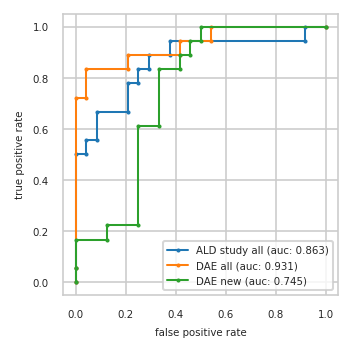

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.500   0.000 0.722   0.000 0.167
3          0.042 0.500   0.042 0.722   0.125 0.167
4          0.042 0.556   0.042 0.833   0.125 0.222
5          0.083 0.556   0.208 0.833   0.250 0.222
6          0.083 0.667   0.208 0.889   0.250 0.611
7          0.208 0.667   0.417 0.889   0.333 0.611
8          0.208 0.778   0.417 0.944   0.333 0.833
9          0.250 0.778   0.542 0.944   0.417 0.833
10         0.250 0.833   0.542 1.000   0.417 0.889
11         0.292 0.833   1.000 1.000   0.458 0.889
12         0.292 0.889     NaN   NaN   0.458 0.944
13         0.375 0.889     NaN   NaN   0.500 0.944
14         0.375 0.944     NaN   NaN   0.500 1.000
15         0.917 0.944     NaN   NaN   1.000 1.000
16         0.917 1.000     NaN   NaN     NaN   NaN
17         1.000 1.000     NaN   NaN     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F6VDH7;P50502;Q3KNR6,Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9U...,A0A0J9YW36;Q9NZ72;Q9NZ72-2
2,Q92743,P02741,P51688
3,P04075,Q13433,P31321
4,P61981,P61981,Q96GD0
5,P14174,Q9Y2T3;Q9Y2T3-3,K7EPJ5;O60291;O60291-2;O60291-3;O60291-4
6,A0A0C4DGY8;D6RA00;Q9UHY7,P04075,Q8TEA8
7,P05413;S4R371,P14174,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,P08294,A0A0C4DGY8;D6RA00;Q9UHY7,E9PK25;G3V1A4;P23528


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


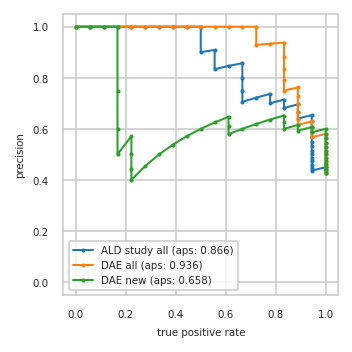

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.545 1.000
10         0.531 0.944     0.562 1.000     0.562 1.000
11         0.548 0.944     0.581 1.000     0.581 1.000
12         0.567 0.944     0.567 0.944     0.600 1.000
13         0.586 0.944     0.586 0.944     0.586 0.944
14         0.607 0.944     0.607 0.944     0.607 0.944
15         0.630 0.944     0.630 0.944     0.593 0.889
16         0.654 0.944     0.615 0.889     0.615 0.889
17         0.640 0.889     0.640 0.889     0.600 0.833
18         0.667 0.889     0.667 0.889     0.625 0.833
19         0.696 0.889     0.696 0.889     0.652 0.833
20         0.682 0.833     0.727 0.889     0.636 0.778
21         0.714 0.833     0.762 0.889     0.619 0.722
22         0.700 0.778     0.750 0.833     0.600 0.667
23         0.737 0.778     0.789 0.833     0.579 0.611
24         0.722 0.722     0.833 0.833     0.611 0.611
25         0.706 0.667     0.882 0.833     0.647 0.611
26         0.750 0.667     0.938 0.833     0.625 0.556
27         0.800 0.667     0.933 0.778     0.600 0.500
28         0.857 0.667     0.929 0.722     0.571 0.444
29         0.846 0.611     1.000 0.722     0.538 0.389
30         0.833 0.556     1.000 0.667     0.500 0.333
31         0.909 0.556     1.000 0.611     0.455 0.278
32         0.900 0.500     1.000 0.556     0.400 0.222
33         1.000 0.500     1.000 0.500     0.444 0.222
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


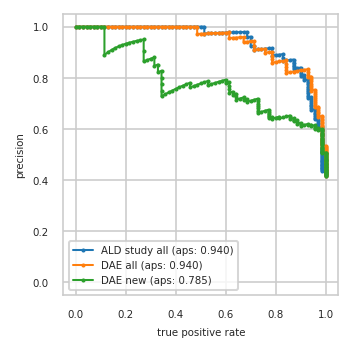

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


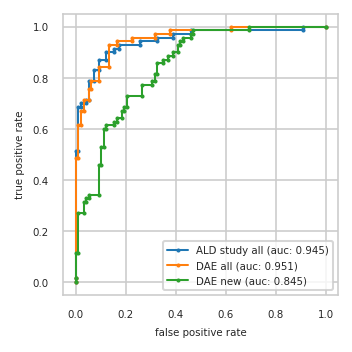

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}